In [1]:
import string
import re
from pickle import dump
from pickle import load
from unicodedata import normalize
from numpy import array
from numpy import argmax
from numpy.random import rand
from numpy.random import shuffle
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, RepeatVector, TimeDistributed, Dense
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import corpus_bleu
import pydot 
import graphviz

Using TensorFlow backend.
/Users/bl4z3/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/bl4z3/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/bl4z3/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/bl4z3/miniconda3/lib/python3.7/site-packages/t

In [2]:
 	
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [3]:
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs

In [4]:
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)

In [5]:

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs
 
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# load dataset
filename = 'deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(100):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[go on] => [mach weiter]
[hello] => [hallo]
[i ran] => [ich rannte]
[i see] => [ich verstehe]
[i see] => [aha]
[i try] => [ich probiere es]
[i won] => [ich hab gewonnen]
[i won] => [ich habe gewonnen]
[smile] => [lacheln]
[cheers] => [zum wohl]
[freeze] => [keine bewegung]
[freeze] => [stehenbleiben]
[got it] => [kapiert]
[got it] => [verstanden]
[got it] => [einverstanden]
[he ran] => [er rannte]
[he ran] => [er lief]
[hop in] => [mach mit]
[hug me] => [druck mich]
[hug me] => [nimm mich in den arm]
[hug me] => [umarme mich]
[i fell] => [ich fiel]
[i fell] => [ich fiel hin]
[i fell] => [ich sturzte]
[i fell] => [ich bin hingefallen]
[i fell] => [ich bin gesturzt]
[i know] => [ich wei]
[i lied] => [ich habe gelogen]
[i lost] => [ich habe verloren]
[i paid] => [ich habe bezah

In [6]:


# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [7]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

In [8]:
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [9]:
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

In [10]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

English Vocabulary Size: 2233
English Max Length: 5
German Vocabulary Size: 3566
German Max Length: 10


In [11]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

In [12]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

In [13]:
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 256)           912896    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 2233)           573881    
Total params: 2,537,401
Trainable params: 2,537,401
Non-trainable params: 0
_________________________________________________________________
None


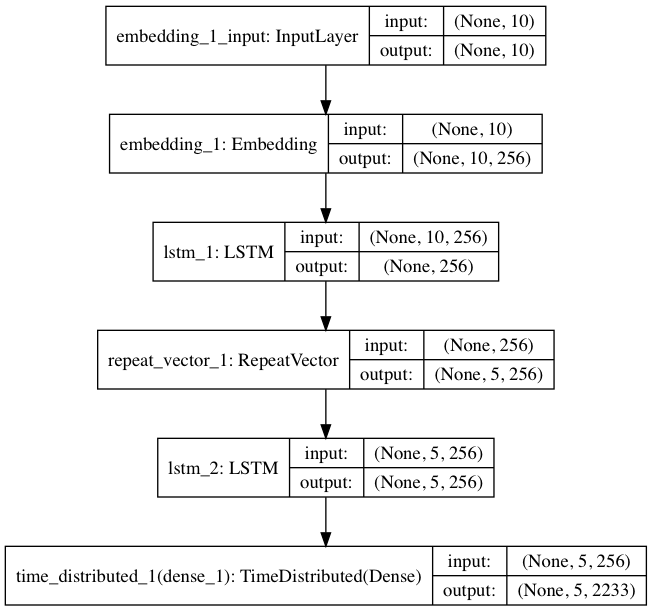

In [14]:
# define NMT model

def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [15]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)


Train on 9000 samples, validate on 1000 samples
Epoch 1/30
 - 39s - loss: 4.1955 - val_loss: 3.4330

Epoch 00001: val_loss improved from inf to 3.43298, saving model to model.h5
Epoch 2/30
 - 39s - loss: 3.3044 - val_loss: 3.2851

Epoch 00002: val_loss improved from 3.43298 to 3.28514, saving model to model.h5
Epoch 3/30
 - 39s - loss: 3.1786 - val_loss: 3.2069

Epoch 00003: val_loss improved from 3.28514 to 3.20691, saving model to model.h5
Epoch 4/30
 - 39s - loss: 3.0413 - val_loss: 3.0797

Epoch 00004: val_loss improved from 3.20691 to 3.07975, saving model to model.h5
Epoch 5/30
 - 40s - loss: 2.8701 - val_loss: 2.9486

Epoch 00005: val_loss improved from 3.07975 to 2.94856, saving model to model.h5
Epoch 6/30
 - 40s - loss: 2.7231 - val_loss: 2.8411

Epoch 00006: val_loss improved from 2.94856 to 2.84110, saving model to model.h5
Epoch 7/30
 - 44s - loss: 2.5725 - val_loss: 2.7388

Epoch 00007: val_loss improved from 2.84110 to 2.73881, saving model to model.h5
Epoch 8/30
 - 43s

In [16]:

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[er ist ein meckerfritze], target=[hes a grouch], predicted=[hes a grouch]
src=[ich heie tom], target=[my names tom], predicted=[my names tom]
src=[tom ist einfaltig], target=[tom is simple], predicted=[tom is simple]
src=[fuhl mal], target=[feel this], predicted=[am this]
src=[ich sehe tom], target=[i see tom], predicted=[i see tom]
src=[kannst du es aufmachen], target=[can you open it], predicted=[can you open it]
src=[tom telefonierte], target=[tom phoned], predicted=[tom phoned]
src=[ist sie zu hause], target=[is she at home], predicted=[is it at home]
src=[ich nehme es], target=[ill take it], predicted=[i take it it]
src=[tom fehlt mir], target=[i miss tom], predicted=[i miss tom]
BLEU-1: 0.871802
BLEU-2: 0.816750
BLEU-3: 0.725731
BLEU-4: 0.423979
test
src=[es ist eine regel], target=[its a rule], predicted=[this is a book]
src=[er wird uberleben], target=[he will survive], predicted=[he gets]
src=[selbst tom hat geweint], target=[even tom cried], predicted=[was tom smil

## How much effort is put into data preparation vs. actually training and evaluating the model?
One could easily say that more effort is put into the preprocessing rather than the training and evaluation. However, I think that both steps have their fair share of work and burden. With preprocessing the user has to understand what the data is being used for and how to best prepare the data for that goal. The implementation of neural networks can be an absolute pain with shape errors abounding, so there is a definite difficulty to those as well. I think an equal amount of effort is put inot both.

## What constitutes the input features? What constitutes the top layer?

Well the top layer is word embeddings. I think our features are vectors of german words.

## What does it mean that this is a "generative" classifier? How is that different from a discriminative classifier?

This generates results and then evaluates them rather than chooses between one result or another. When we look at the output of the tests we can see that our neural network produces text, it does not determine whether text is one thing or another, it does not determine it.

## How do you know your model works? What does a BLEU metric tell you? Can you think of a better way to evaluate MT output?

Well, as the question states, there is the BLEU metric, and it can tell in degrees of n-grams how effective the translation is. One would imagine that if there was a better metric or way to evaluate the MT output it would be widely known and in use. In class I suggested manual annotation. We could try precision@K, though that seems like n-grams. The shortcoming of bleu seems to be sentence length material, since most sentences are longer than 4 words. The problem is that the text is not just a text, but there is a tone and a meaning and subtext to words as well, so evaluating a translation is something that writers have trouble with, much less machine learning algorithms.
